# Quant DCA ETF Strategy 📈
Enhanced with equity curve and performance metrics visualizations.

# ETF Long-Term Buy & Hold Strategy Notebook
This notebook implements the SPY/QQQ DCA strategy with 200-day MA filtering.

In [118]:
import os,sys
from pathlib import Path

In [119]:
PROJECT_ROOT = Path.cwd().parents[0]
CWD = Path(os.getcwd())
# DUCKDB_PATH = PROJECT_ROOT / "data" / "processed" / "alpaca" / "minute.duckdb"
TBL_DAILY = PROJECT_ROOT / "data" / "processed" / "alpaca" / "price.duckdb"
TBL_MINUTE = PROJECT_ROOT / "data" / "processed" / "alpaca" / "minute.duckdb"

print(f"Project Root: {PROJECT_ROOT}")
print(f"Working directory: {CWD}")

Project Root: C:\Users\luyanda\workspace\QuantTrade
Working directory: C:\Users\luyanda\workspace\QuantTrade\notebooks


In [120]:
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
from utils.data_fetch import get_price_data

## 1. Setup

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

In [122]:
# Define strategy parameters
START_DATE = "2008-01-01"
END_DATE = "2025-08-01"

ETFS = ["SPY", "QQQ", "SPLV", "SHY"]
ALLOCATION_PER_MONTH = 500  # USD
CORE_ALLOCATION = {"SPY": 0.5, "QQQ": 0.5}
FALLBACK_ETFS = ["SPLV", "SHY"]
HOLD_PERIOD_MONTHS = 6
REBALANCE_FREQ = "Q"  # Quarterly
TREND_LOOKBACK = 200  # days for moving average filter


## 2. Data Ingestion

In [123]:
# --- Ingest latest minute-level data ---
minute_data = {}

with duckdb.connect(str(TBL_MINUTE)) as con:
    for symbol in ETFS:
        table_name = f"minute_{symbol}"

        query = f"""
        SELECT timestamp,symbol,open,high,low,close,volume,trade_count,vwap
        FROM {table_name}
        """
        try:
            df = con.execute(query).fetchdf().sort_values("timestamp")
            df.set_index("timestamp", inplace=True)
            minute_data[symbol] = df
        except Exception as e:
            print(f"Failed to load {symbol}: {e}")

print(minute_data["SPY"].tail())

                          symbol     open     high     low   close   volume  \
timestamp                                                                     
2025-08-04 21:58:00+02:00    SPY  631.145  631.145  631.00  631.01  22496.0   
2025-08-04 21:59:00+02:00    SPY  630.970  631.070  630.88  631.07  37020.0   
2025-08-04 22:00:00+02:00    SPY  631.160  631.270  630.00  630.99  10711.0   
2025-08-04 22:34:00+02:00    SPY  632.080  632.090  632.08  632.08   6892.0   
2025-08-04 22:36:00+02:00    SPY  632.080  632.080  632.08  632.08   7897.0   

                           trade_count        vwap  
timestamp                                           
2025-08-04 21:58:00+02:00        176.0  631.046452  
2025-08-04 21:59:00+02:00        323.0  630.943229  
2025-08-04 22:00:00+02:00         20.0  630.582374  
2025-08-04 22:34:00+02:00         11.0  632.080174  
2025-08-04 22:36:00+02:00         13.0  632.080000  


In [124]:
# --- Ingest latest daily data ---
# Load the last 200 days of data for each ETF from DuckDB
daily_data = {}

with duckdb.connect(TBL_DAILY) as con:
    for symbol in ETFS:
        table_name = f"daily_{symbol}"

        query = f"""
        SELECT timestamp,symbol,open,high,low,close,volume,trade_count,vwap
        FROM {table_name}
        ORDER BY timestamp DESC
        LIMIT 200
        """
        try:
            df = con.execute(query).fetchdf().sort_values("timestamp")
            df.set_index("timestamp", inplace=True)
            daily_data[symbol] = df
        except Exception as e:
            print(f"Failed to load {symbol}: {e}")
print(daily_data["SPY"].tail())

                          symbol    open    high      low   close     volume  \
timestamp                                                                      
2025-07-30 06:00:00+02:00    SPY  636.00  637.63  631.630  634.56  1379785.0   
2025-07-31 06:00:00+02:00    SPY  639.46  639.84  630.780  631.90  1442218.0   
2025-08-01 06:00:00+02:00    SPY  626.33  626.33  619.310  621.74  2811106.0   
2025-08-04 06:00:00+02:00    SPY  625.72  631.19  625.600  631.07  1152237.0   
2025-08-05 06:00:00+02:00    SPY  631.79  632.60  627.065  630.05   556099.0   

                           trade_count        vwap  
timestamp                                           
2025-07-30 06:00:00+02:00      17346.0  634.992220  
2025-07-31 06:00:00+02:00      14878.0  635.272338  
2025-08-01 06:00:00+02:00      32133.0  622.135746  
2025-08-04 06:00:00+02:00      13591.0  629.618168  
2025-08-05 06:00:00+02:00       8898.0  629.292562  


In [125]:
# Combine all symbols into a wide DataFrame
daily_prices = pd.concat(
    {sym: df['close'] for sym, df in daily_data.items()}, axis=1
)
daily_prices.columns = ETFS  # Flatten MultiIndex


In [126]:
features_df = daily_prices.copy()

for symbol in ETFS:
    features_df[f"{symbol}_200ma"] = daily_prices[symbol].rolling(window=200).mean()
    features_df[f"{symbol}_signal"] = (daily_prices[symbol] > features_df[f"{symbol}_200ma"]).astype(int)


## 3. Feature Engineering

In [127]:
summary = []

for symbol in ETFS:
    minute_df = minute_data[symbol]
    daily_df = daily_data[symbol]

    # Calculate 200-day moving average from daily close
    ma_200 = daily_df['close'].rolling(window=200).mean().iloc[-1]

    # Get the latest 1-minute close price
    latest_price = minute_df['close'].iloc[-1]

    # Determine signal: Buy if price >= 200 MA
    signal = int(latest_price >= ma_200)

    summary.append({
        "Symbol": symbol,
        "Latest Price": latest_price,
        "200-day MA": ma_200,
        "Signal (1=Buy)": signal
    })

signal_df = pd.DataFrame(summary)
display(signal_df)


,Symbol,Latest Price,200-day MA,Signal (1=Buy)
0,SPY,632.080,588.875550,1
1,QQQ,565.280,511.507100,1
2,SPLV,73.115,72.364600,1
3,SHY,82.680,82.343625,1


## 5. Intraday (1-min) ETF Prices vs 200-day Moving Average

This chart visualizes the **intraday 1-minute price action** of each ETF (SPY, QQQ, SPLV, SHY) relative to its **long-term 200-day moving average (MA)**.

1. Load the most recent intraday prices (1-minute resolution)
2. Load the latest 200-day moving average from daily data
3. Plot both on the same chart for comparison
4. Indicate whether it's a good day to invest (i.e. price above 200-day MA)


The **200-day MA** serves as a trend-following filter:
- When **price is above** the 200-day MA, the asset is considered to be in a long-term **uptrend**.
- When **price is below** the 200-day MA, it signals a potential **downtrend or weakness**.


#### ✅ Allocation Rules:
- **If SPY is above its 200-day MA** → Allow contribution to SPY this month.
- **If SPY is below its 200-day MA** → Redirect SPY contribution to SPLV (or SHY).
- **If QQQ is above its 200-day MA** → Allow contribution to QQQ this month.
- **If QQQ is below its 200-day MA** → Redirect QQQ contribution to SPLV (or SHY).
- **If both SPY and QQQ are below their 200-day MAs** → Go fully defensive: allocate entire amount to SPLV or SHY, depending on which is above its MA.

#### 🕒 Why Intraday View?
Markets often gap or trend early in the session. Checking current price against the 200-day MA on a **1-minute basis** just before execution (e.g., around 10:00 AM ET) lets us make precise and **rule-based allocation decisions** on the day of purchase.


In [128]:
# --- Get today's intraday data ---
minute_df = minute_data[symbol].sort_index()
today = minute_df.index[-1].normalize()
minute_df = minute_df[minute_df.index.normalize() == today]


In [129]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

rows, cols = 2, 2

fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"{etf} Intraday vs 200MA" for etf in ETFS],
    shared_xaxes=False,
    shared_yaxes=False
)

for i, symbol in enumerate(ETFS):
    row = i // cols + 1
    col = i % cols + 1

    # --- Filter to today's intraday data ---
    minute_df = minute_data[symbol].sort_index()
    today = minute_df.index[-1].normalize()
    minute_df = minute_df[minute_df.index.normalize() == today]

    # --- Skip if no 'close' column ---
    if 'close' not in minute_df.columns:
        print(f"Skipping {symbol} – no 'close' column found.")
        continue

    # --- Get latest 200-day MA ---
    try:
        ma_value = features_df[f"{symbol}_200ma"].dropna().iloc[-1]
    except KeyError:
        print(f"Skipping {symbol} – 200-day MA not found in features.")
        continue
    
    # --- Plot intraday price ---
    fig.add_trace(
        go.Scatter(
            x=minute_df.index,
            y=minute_df['close'],
            mode='lines',
            name=f"{symbol} Intraday",
            line=dict(color='deepskyblue'),
            showlegend=False
        ),
        row=row,
        col=col
    )

    # --- Plot 200-day MA as flat line ---
    fig.add_trace(
        go.Scatter(
            x=minute_df.index,
            y=[ma_value] * len(minute_df),
            mode='lines',
            name='200-Day MA',
            line=dict(color='orange', dash='dash'),
            showlegend=False
        ),
        row=row,
        col=col
    )

# Layout tweaks
fig.update_layout(
    title_text="📈 Intraday (1-min) ETF Prices vs 200-Day Moving Average",
    height=800,
    template="plotly_dark"
)

fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="Price (USD)")

# 🔥 REQUIRED: Display the chart
fig.show()


In [130]:
for symbol in ETFS:
    minute_df = minute_data[symbol].sort_index()
    latest_price = minute_df['close'].iloc[-1]
    ma_value = features_df[f"{symbol}_200ma"].dropna().iloc[-1]
    
    status = "✅ ABOVE" if latest_price > ma_value else "🚫 BELOW"
    print(f"{symbol}: {latest_price:.2f} is {status} the 200-day MA ({ma_value:.2f})")


SPY: 632.08 is ✅ ABOVE the 200-day MA (588.88)
QQQ: 565.28 is ✅ ABOVE the 200-day MA (511.51)
SPLV: 73.11 is ✅ ABOVE the 200-day MA (72.36)
SHY: 82.68 is ✅ ABOVE the 200-day MA (82.34)


## 5. Strategy Logic

Strategy Rules (Execution Logic)
- Invest $500/month:
  - Default split: 50% SPY, 50% QQQ

- 200-day MA Filter (per ETF):
  - If ETF ≥ 200 MA → ✅ buy normally
  - If ETF < 200 MA → 🔁 redirect that portion to SPLV or SHY, with preference to:
    - SPLV if above 200 MA
    - SHY if SPLV also < 200 MA
    - If both < 200 MA → Hold in cash until next month

- Dividends: Reinvest
- No selling of existing holdings for first 6 months

- Quarterly rebalancing of new contributions to maintain target weights

In [131]:
# def run_strategy(daily_prices, features_df, lookback=200):
#     monthly_dates = daily_prices.resample("MS").last().index  # Month start
#     portfolio_value = []
#     holdings = {etf: 0 for etf in ETFS}
#     cash = 0
#     purchase_log = []

#     # Track when each lot was purchased
#     purchase_history = []

#     for date in monthly_dates:
#         if date not in features_df.index:
#             continue

#         prices_today = features_df.loc[date, ETFS]
#         signals_today = features_df.loc[date, [f"{etf}_signal" for etf in ETFS]]

#         # Determine whether it's a rebalancing month
#         rebalance = date.to_period("M").month % 3 == 1  # every 3 months starting Jan

#         monthly_cash = ALLOCATION_PER_MONTH

#         for etf in CORE_ALLOCATION:
#             weight = CORE_ALLOCATION[etf]
#             etf_cash = monthly_cash * weight
#             signal = signals_today[f"{etf}_signal"]
#             price = prices_today[etf]

#             if signal == 1:
#                 shares = etf_cash / price
#                 holdings[etf] += shares
#                 purchase_history.append((date, etf, shares))
#             else:
#                 # 200MA fail → Fallback
#                 fallback = None
#                 for fallback_etf in FALLBACK_ETFS:
#                     if signals_today[f"{fallback_etf}_signal"] == 1:
#                         fallback = fallback_etf
#                         break

#                 if fallback:
#                     fallback_price = prices_today[fallback]
#                     shares = etf_cash / fallback_price
#                     holdings[fallback] += shares
#                     purchase_history.append((date, fallback, shares))
#                 else:
#                     cash += etf_cash  # sit in cash

#         # Track portfolio value
#         current_value = sum(holdings[sym] * prices_today[sym] for sym in ETFS) + cash
#         portfolio_value.append((date, current_value))

#     return pd.DataFrame(portfolio_value, columns=["Date", "Portfolio Value"]).set_index("Date")


In [ ]:
def run_strategy(minute_data, daily_data, start_date, end_date, monthly_investment=500):
    portfolio = []
    cash = 0.0
    holdings = {symbol: 0.0 for symbol in ETFS}
    cost_basis = {symbol: 0.0 for symbol in ETFS}

    invest_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

    for date in invest_dates:
        signals = {}

        for symbol in ETFS:
            daily_df = daily_data[symbol]
            minute_df = minute_data[symbol]

            # Remove timezone for comparison
            if minute_df.index.tz is not None:
                minute_df = minute_df.copy()
                minute_df.index = minute_df.index.tz_convert(None)

            try:
                # 200-day MA check
                history = daily_df[daily_df.index <= date]['close']
                if len(history) < 200:
                    print(f"⚠️ {symbol} insufficient daily history on {date.date()}")
                    signals[symbol] = False
                    continue

                ma_200 = history.rolling(window=200).mean().iloc[-1]

                # Intraday price check
                intraday_today = minute_df[minute_df.index.normalize() == date.normalize()]
                if intraday_today.empty:
                    print(f"⚠️ {symbol} no intraday data on {date.date()}")
                    signals[symbol] = False
                    continue

                latest_price = intraday_today['close'].iloc[-1]
                signals[symbol] = latest_price >= ma_200

                print(f"{symbol} on {date.date()}: MA={ma_200:.2f} vs Price={latest_price:.2f} → Signal={signals[symbol]}")

            except Exception as e:
                print(f"❌ Error processing {symbol} on {date.date()}: {e}")
                signals[symbol] = False

        # Monthly allocation logic
        allocation = {"SPY": 0.5 * monthly_investment, "QQQ": 0.5 * monthly_investment}
        fallback = {"SPY": "SPLV", "QQQ": "SPLV"}

        for etf in ["SPY", "QQQ"]:
            amount = allocation[etf]

            # Helper to get intraday price
            def get_latest_price(symbol):
                df = minute_data[symbol]
                if df.index.tz is not None:
                    df = df.copy()
                    df.index = df.index.tz_convert(None)
                intraday_today = df[df.index.normalize() == date.normalize()]
                return intraday_today['close'].iloc[-1] if not intraday_today.empty else None

            if signals.get(etf, False):
                price = get_latest_price(etf)
                if price:
                    qty = amount / price
                    holdings[etf] += qty
                    cost_basis[etf] += amount
            else:
                alt = fallback[etf]
                if signals.get(alt, False):
                    price = get_latest_price(alt)
                    if price:
                        qty = amount / price
                        holdings[alt] += qty
                        cost_basis[alt] += amount
                elif signals.get("SHY", False):
                    price = get_latest_price("SHY")
                    if price:
                        qty = amount / price
                        holdings["SHY"] += qty
                        cost_basis["SHY"] += amount
                else:
                    cash += amount  # fallback to cash

        # Portfolio valuation
        total_value = cash
        for sym in holdings:
            price = get_latest_price(sym)
            if price:
                total_value += holdings[sym] * price

        print(f"[{date.date()}] Buy signals: {signals}, Cash: {cash:.2f}")

        portfolio.append({
            "Date": date,
            "Portfolio Value": total_value,
            "Cash": cash
        })

    return pd.DataFrame(portfolio).set_index("Date")


In [154]:
start_date = pd.Timestamp("2023-08-01")
end_date = pd.Timestamp("2025-08-01")

# Run backtest
portfolio_df = run_strategy(minute_data, daily_data, start_date, end_date)

# Preview
portfolio_df.tail()


UnboundLocalError: cannot access local variable 'minute_df' where it is not associated with a value

## 6. Performance Evaluation

In [103]:

import numpy as np

def evaluate_performance(portfolio_df, risk_free_rate=0.00):
    df = portfolio_df.copy()

    # Calculate daily returns
    df["Returns"] = df["Portfolio Value"].pct_change()
    df = df.dropna()

    # CAGR
    start_val = df["Portfolio Value"].iloc[0]
    end_val = df["Portfolio Value"].iloc[-1]
    n_years = (df.index[-1] - df.index[0]).days / 365.25
    CAGR = (end_val / start_val) ** (1 / n_years) - 1

    # Annualized volatility
    volatility = df["Returns"].std() * np.sqrt(252)

    # Sharpe Ratio (risk-free assumed 0)
    sharpe = (CAGR - risk_free_rate) / volatility if volatility > 0 else np.nan

    # Maximum Drawdown
    cum_max = df["Portfolio Value"].cummax()
    drawdown = df["Portfolio Value"] / cum_max - 1
    max_drawdown = drawdown.min()

    return CAGR, volatility, sharpe, max_drawdown


In [104]:
CAGR, volatility, sharpe, max_dd = evaluate_performance(portfolio_df)

print(f"CAGR: {CAGR:.2%}")
print(f"Annual Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")


CAGR: 273.55%
Annual Volatility: 332.66%
Sharpe Ratio: 0.82
Max Drawdown: 0.00%


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_equity_and_drawdown(portfolio_df):
    df = portfolio_df.copy()
    df['Cumulative Max'] = df['Portfolio Value'].cummax()
    df['Drawdown'] = df['Portfolio Value'] / df['Cumulative Max'] - 1

    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        subplot_titles=("Equity Curve", "Drawdown"),
                        vertical_spacing=0.1)

    # Equity Curve
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['Portfolio Value'],
            name="Equity Curve",
            line=dict(color="#00CCFF", width=2)
        ),
        row=1, col=1
    )

    # Drawdown
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['Drawdown'],
            name="Drawdown",
            fill='tozeroy',
            line=dict(color="orange")
        ),
        row=2, col=1
    )

    # Layout
    fig.update_layout(
        height=600,
        title="Portfolio Equity and Drawdown",
        title_x=0.5,
        template='plotly_dark',
        showlegend=False,
        margin=dict(t=50, b=40, l=50, r=50)
    )

    fig.update_yaxes(title_text="Portfolio Value ($)", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown (%)", tickformat=".0%", row=2, col=1)

    fig.update_xaxes(title_text="Date", row=2, col=1)

    fig.show()


In [ ]:
# Evaluate performance 
CAGR, volatility, sharpe, max_drawdown = evaluate_performance(portfolio_df)

print(f"CAGR: {CAGR:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


IndexError: single positional indexer is out-of-bounds

In [ ]:
# # Run backtest
# portfolio_df = run_strategy(daily_prices, features_df, lookback=200)

# # Evaluate performance (optional)
# # cagr, vol, sharpe, mdd = evaluate_performance(portfolio_df)
# performance_metrics, evaluated_df = evaluate_performance(portfolio_df)



IndexError: single positional indexer is out-of-bounds

## 7. Sensitivty Analysis

What if the trend filter uses 100, 125, 150, ..., 300 days?

- Is Sharpe ratio peaking around a certain lookback?
- Does max drawdown increase with shorter filters?
- Is there a sweet spot that balances return vs risk?

In [ ]:
# 📊 Plotting equity curve and drawdown
# plot_equity_and_drawdown(portfolio_df)

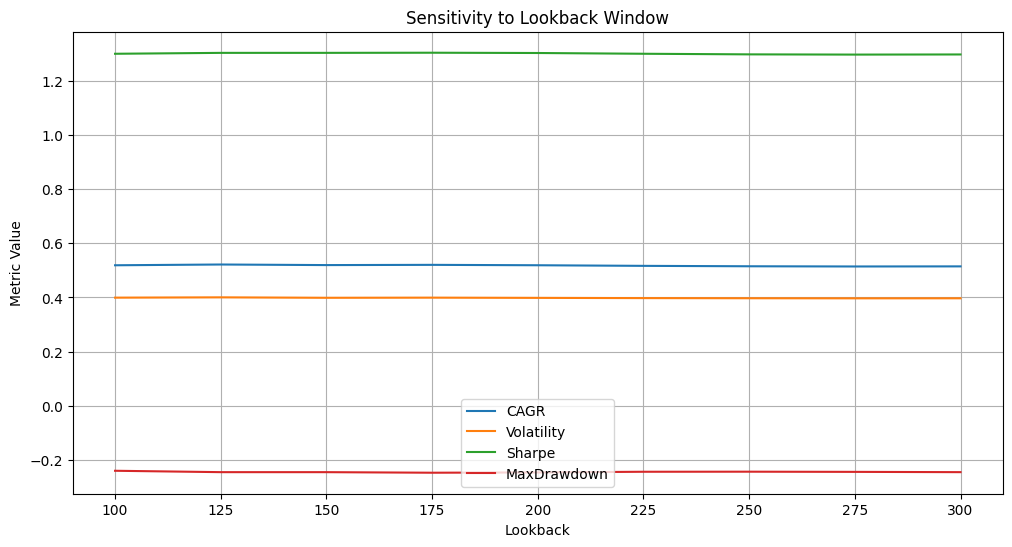

,CAGR,Volatility,Sharpe,MaxDrawdown
Lookback,,,,
100,0.518775,0.399256,1.299355,-0.239627
125,0.521608,0.400413,1.302677,-0.244734
150,0.519462,0.398754,1.302715,-0.244763
175,0.520333,0.399269,1.303217,-0.246835
200,0.518852,0.398450,1.302176,-0.245774
225,0.516617,0.397588,1.299379,-0.243280
250,0.515089,0.397092,1.297154,-0.243024
275,0.514335,0.396768,1.296310,-0.243695
300,0.514698,0.396897,1.296804,-0.244742


In [ ]:
# lookbacks = range(100, 301, 25)
# results = []

# for lb in lookbacks:
#     features = compute_features(price_data, lb)
#     portfolio = run_strategy(price_data, features, lb)
#     CAGR, vol, sharpe, mdd = evaluate_performance(portfolio)
#     results.append({"Lookback": lb, "CAGR": CAGR, "Volatility": vol, "Sharpe": sharpe, "MaxDrawdown": mdd})

# sensitivity_df = pd.DataFrame(results)
# sensitivity_df.set_index("Lookback", inplace=True)
# sensitivity_df.plot(title="Sensitivity to Lookback Window", figsize=(12, 6), grid=True)
# plt.ylabel("Metric Value")
# plt.show()

# sensitivity_df